# ABOUT:
- In this notebook I:
    1. **Tokenized** the "text" columns in preparation as input for a transformers model

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\tanch\Documents\GitHub\Spam Detection (local)\data\smsdata.txt", sep = "\t",names = ['label','text'])

In [3]:
from datasets import ClassLabel, Sequence
import pandas as pd
from IPython.display import display, HTML
def show_elements(dataset, randomize = True, num_samples = 10):
    
    if isinstance(dataset,pd.DataFrame):                  # if DataFrame 
        if randomize:                                          # if random> shuffle
            dataset = dataset.sample(frac=1)
        display(HTML(dataset.iloc[:num_samples].to_html()))             # take first n rows
    
    else:                                                    # if not DataFrame
        if randomize:                                           # if random> shuffle
            dataset = dataset.shuffle()   
        dataset = pd.DataFrame(dataset.select(range(num_samples)))   # convert first n rows to dataframe
        display(HTML(dataset.to_html()))
    

In [4]:
show_elements(df,randomize = False, num_samples = 10)

,label,text
0,good,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,good,Ok lar... Joking wif u oni...
2,spam,f
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,good,Even my brother is not like to speak with me. They treat me like aids patent.
7,good,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


## len
- rather small dataset

In [5]:
len(df)

5572

## Target Imbalance
- to deal with target imbalance, we could use textual augmentation to increase the number of spam emails

In [6]:
df.label.value_counts()

good    4825
spam     747
Name: label, dtype: int64

## label encoding

In [7]:
df.label = df.label.map({"good":0,"spam":1})

## Sequence Lengths
- based on the histplot, we could choose 70 as max_length as it covers most emails

In [8]:
from transformers import AutoTokenizer
model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [9]:
def get_sequence_lengths(examples):
    examples["sequence_length"] = list(map(len,tokenizer(examples['text'])['input_ids']))
    return examples

In [10]:
from datasets import Dataset
spam_Dataset = Dataset.from_pandas(df)

In [11]:
spam_Dataset = spam_Dataset.map(get_sequence_lengths,batched=True)

<AxesSubplot:ylabel='Count'>

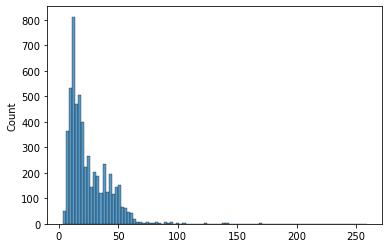

In [12]:
import seaborn as sns
sns.histplot(spam_Dataset['sequence_length'])

## train_test_split

In [13]:
spam_Dataset = spam_Dataset.train_test_split(0.3,
                                             seed=0)   # need to set seed reproducibility and comparability later on!
spam_Dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'sequence_length', 'text'],
        num_rows: 3900
    })
    test: Dataset({
        features: ['label', 'sequence_length', 'text'],
        num_rows: 1672
    })
})

## tokenize

In [14]:
max_length = 100

In [15]:
def tokenize(examples):
    return tokenizer(examples['text'],
                     max_length = max_length,
                     padding = "max_length",
                     truncation = True)

In [16]:
tokenized_spam_Dataset = spam_Dataset.map(tokenize)

In [17]:
tokenized_spam_Dataset.remove_columns_(["sequence_length","text"])

In [18]:
show_elements(tokenized_spam_Dataset['train'], randomize = True, num_samples = 5)

,attention_mask,input_ids,label
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1106, 47, 214, 45, 11, 127, 512, 11, 41, 1946, 8, 10, 457, 38, 437, 164, 6256, 4891, 405, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 30086, 1615, 5193, 6, 16, 452, 18, 529, 1474, 116, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 530, 449, 35, 43, 5278, 29, 7359, 19, 162, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
3,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 31535, 6, 38, 581, 486, 423, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 791, 267, 45570, 45851, 3034, 12502, 66, 19, 1100, 7, 6255, 36649, 8, 2242, 927, 8461, 6625, 4, 305, 41407, 4, 6002, 1517, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0


## export

In [19]:
tokenized_spam_Dataset.save_to_disk(r"C:\Users\tanch\Documents\GitHub\Spam Detection (local)\data\tokenized_spam_Dataset")